In [1]:
import datetime
import random

import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import seaborn as sns
import mplfinance as mpf
import yfinance as yf

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from matplotlib import pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from numpy.lib.stride_tricks import sliding_window_view

from setup import get_task_data

SEED_VALUE = 42

random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

d:\conda\envs\imta\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
financial_data = {}
metadata = {}

# Stocks have different IPO date (first trade) so only last ~3 years of data used
HISTORY_SIZE = 129
TARGET_STOCKS_COUNT = 5000

stocks_df = pd.read_csv(get_task_data("StocksList.csv"))

stocks_list = stocks_df['Symbol'].astype(str).to_list()
stocks_list = list(map(lambda s: s.replace('^', '-'), stocks_list))
random.shuffle(stocks_list)

stocks_list = stocks_list[:TARGET_STOCKS_COUNT]

tickers = stocks_list
tickers_df = yf.download(tickers, period='1y')

[***********           23%%                      ]  1174 of 5000 completed

Failed to get ticker 'BRK/A' reason: Expecting value: line 1 column 1 (char 0)


[**********************51%%                      ]  2557 of 5000 completed

Failed to get ticker 'CRD/B' reason: Expecting value: line 1 column 1 (char 0)


[**********************56%%*                     ]  2803 of 5000 completed

Failed to get ticker 'BF/A' reason: Expecting value: line 1 column 1 (char 0)


[**********************69%%*******               ]  3436 of 5000 completed

Failed to get ticker 'WSO/B' reason: Expecting value: line 1 column 1 (char 0)


[**********************76%%**********            ]  3780 of 5000 completed

Failed to get ticker 'CRD/A' reason: Expecting value: line 1 column 1 (char 0)


[**********************92%%******************    ]  4598 of 5000 completed

Failed to get ticker 'AKO/A' reason: Expecting value: line 1 column 1 (char 0)


[*********************100%%**********************]  5000 of 5000 completed


306 Failed downloads:
['GSL-B', 'GDV-H', 'MS-A', 'SPNT-B', 'SRC-A', 'NSA-A', 'AIG-A', 'RITM-C', 'GGT-E', 'AHL-C', 'AHT-D', 'LFT-A', 'AMH-G', 'PCG-A', 'USB-Q', 'ACP-A', 'DLR-K', 'GNL-E', 'GAB-G', 'NGL-B', 'EFC-B', 'RLJ-A', 'KEY-J', 'SAND          ', 'AEL-B', 'DUK-A', 'ET-E', 'ALL-B', 'AHT-H', 'CODI-B', 'ABR-E', 'PSA-L', 'PBI-B', 'SF-C', 'CLVT-A', 'TRTN-D', 'SCE-L', 'CIM-B', 'JPM-C', 'CTA-B', 'WFC-L', 'ATH-C', 'PRIF-H', 'CIM-A', 'FHN-D', 'GTLS-B', 'CEQP-', 'ABR-D', 'AGM-E', 'HFRO-A', 'AL-A', 'BFS-D', 'WAL-A', 'REXR-B', 'TWO-B', 'WRB-G', 'USB-R', 'NREF-A', 'KIM-M', 'RPT-D', 'NCV-A', 'RITM-B', 'OPP-B', 'RITM-A', 'COF-I', 'CORR-A', 'GNL-A', 'C-J', 'RWT-A', 'NS-C', 'SCE-H', 'ARR-C', 'USB-A', 'WBS-G', 'HIG-G', 'CLDT-A', 'SPG-J', 'UMH-D', 'MTB-H', 'PRE-J', 'OAK-A', 'KEY-K', 'YCBD-A', 'DLR-J', 'FRT-C', 'CMRE-D', 'WFC-Z', 'PCG-E', 'ATH-B', 'HWM-', 'FHN-F', 'MFA-C', 'ALL-I', 'NLY-G', 'AGM-C', 'SNV-E', 'PEB-F', 'ET-C', 'XFLT-A', 'SR-A', 'WFC-C', 'AUB-A', 'ETX           ', 'MDV-A', 'ECF-A', 'GS-C'

In [3]:
tickers_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 252 entries, 2022-10-25 00:00:00 to 2023-10-25 00:00:00
Columns: 30000 entries, ('Adj Close', 'A') to ('Volume', 'ZYME')
dtypes: float64(26181), int64(3819)
memory usage: 57.7+ MB


In [4]:
tickers_df = tickers_df.iloc[-HISTORY_SIZE:]

In [5]:
stocks_list[0]

'MCACW'

In [6]:
columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

def extract_history(tickers_df, stock):
    multiindex = pd.MultiIndex.from_product([columns, [stock]])
    stock_df = tickers_df[multiindex]

    stock_df.columns = stock_df.columns.to_flat_index()
    stock_df = stock_df.set_axis(columns, axis=1)
    stock_df = stock_df.dropna()
    return stock_df

Our financial data is supplied with metadata: name of a stock and financial sector it belongs too

Sectors:
* Technology - category of stocks relating to the research, development, or distribution of technologically based goods and services
* Basic Materials - category made up of businesses engaged in the discovery, development, and processing of raw materials 
* Communication Services - category made up of services such as social media companies, Internet search firms, video game makers, telecom providers, and streaming media make up most of this sector
* Consumer Cyclical - category of stocks that rely heavily on the business cycle and economic conditions. Consumer cyclicals include industries such as automotive, housing, entertainment, and retail
* Consumer Defensive - category of companies that manufacture food, beverages, household and personal products, packaging, or tobacco. Also includes companies that provide services such as education and training services
* Energy - category of companies that play a role in extracting, refining, or producing sources of energy
* Financial Services - category of firms and institutions that provide financial services to commercial and retail customers
* Healthcare - category of businesses that provide medical services, manufacture medical equipment or drugs, provide medical insurance, or otherwise facilitate the provision of healthcare to patients
* Industrials - category of businesses that aid other businesses in manufacturing, shipping or producing their products
* Real Estate - category of the following: Industrial, Office, Mixed-Industrial/Office, Retail-Shopping Centers, Retail-Regional Malls, Retail-Free Standing, Residential-Apartments, Residential-Manufactured Homes, Diversified, Lodging/Resorts, Health Care, Self Storage, Specialty, Home Financing and Commercial Financing
* Utilities - category of companies that provide their customers with electricity, water, and other public utilities

In [7]:
# metadata extraction is costly and not required for classification/regression

for stock in stocks_list:    
    history = extract_history(tickers_df, stock)
    
    if len(history) < HISTORY_SIZE:
        print(f"Too short history: {len(history)}")
        continue
    
    # ticker = yf.Ticker(stock)
    # sector = ticker.info.get('sector', None)

    # if not sector:
    #    print(f"No sector specified")
    #    continue

    financial_data[stock] = history
    # metadata[stock] = sector

Too short history: 1
Too short history: 128
Too short history: 0
Too short history: 0
Too short history: 1
Too short history: 1
Too short history: 128
Too short history: 108
Too short history: 0
Too short history: 0
Too short history: 31
Too short history: 1
Too short history: 0
Too short history: 1
Too short history: 0
Too short history: 1
Too short history: 128
Too short history: 48
Too short history: 128
Too short history: 0
Too short history: 0
Too short history: 128
Too short history: 1
Too short history: 0
Too short history: 1
Too short history: 0
Too short history: 1
Too short history: 0
Too short history: 0
Too short history: 128
Too short history: 0
Too short history: 0
Too short history: 128
Too short history: 17
Too short history: 0
Too short history: 1
Too short history: 128
Too short history: 128
Too short history: 128
Too short history: 128
Too short history: 128
Too short history: 128
Too short history: 1
Too short history: 1
Too short history: 128
Too short history: 122

In [8]:
len(financial_data)

3877

    1. Classification

Model that predicts if the next close value will be higher than current

RNN classification

In [9]:
def log_modified(n):
    if n == 0:
        return 0
    elif n < 0:
        return -np.log(-n)
    else:
        return np.log(n)

In [10]:
classification_stocks = []
classification_history = []
classification_target = []

for stock, data in financial_data.items():
    classification_stocks.append(stock)

    close_vals = data['Close'].to_numpy()
    close_vals_delta = np.diff(close_vals)
    close_vals_delta = np.insert(close_vals_delta, 0, 0)
    close_vals_delta_normalized = np.fromiter(map(lambda n: log_modified(n), close_vals_delta), dtype=np.float32)

    classification_history.append(close_vals_delta_normalized[0:HISTORY_SIZE - 1])
    classification_target.append(int(close_vals_delta_normalized[-1] > 0))

classification_data = {
    'Stock': classification_stocks,
    'History': classification_history,
    'Target': classification_target
}

In [11]:
classification_df = pd.DataFrame.from_dict(classification_data)

In [12]:
classification_df.sample(1)

,Stock,History,Target
3820,TMCWW,"[0.0, 5.2983155, 4.268698, 6.9077535, -4.34280...",1


Values of close prices represented as a sequence and sector as one-hot vector

In [13]:
classification_train_df, classification_test_df = train_test_split(classification_df, test_size=0.2)

In [14]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

In [15]:
classification_model = tf.keras.Sequential([
    tf.keras.layers.LSTM((HISTORY_SIZE - 1),  return_sequences=True, input_shape=(None, (HISTORY_SIZE - 1))),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM((HISTORY_SIZE - 1),  return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM((HISTORY_SIZE - 1),  return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM((HISTORY_SIZE - 1),  return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM((HISTORY_SIZE - 1),  return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense((HISTORY_SIZE - 1), activation='tanh'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense((HISTORY_SIZE - 1), activation='tanh'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

In [16]:
classification_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              optimizer=tf.keras.optimizers.Adam(1e-6),
              metrics=[
                  'accuracy', 
                  # tfa.metrics.F1Score(average='macro', num_classes=1)
                ])

In [17]:
train_size = len(classification_train_df)
test_size = len(classification_test_df)

x_train = np.array(classification_train_df['History'].tolist()).reshape(train_size, 1, HISTORY_SIZE - 1)
y_train = np.array(classification_train_df['Target'].tolist()).reshape(train_size, 1)

x_test = np.array(classification_test_df['History'].tolist()).reshape(test_size, 1, HISTORY_SIZE - 1)
y_test = np.array(classification_test_df['Target'].tolist()).reshape(test_size, 1)

In [18]:
classification_history = classification_model.fit(x=x_train, y=y_train, validation_data=(x_test, y_test), epochs=500)

Epoch 1/500
97/97 [==============================] - 11s 27ms/step - loss: 4.6213 - accuracy: 0.4025 - val_loss: 4.1196 - val_accuracy: 0.3724
Epoch 2/500
97/97 [==============================] - 1s 9ms/step - loss: 3.8090 - accuracy: 0.4025 - val_loss: 3.8746 - val_accuracy: 0.3724
Epoch 3/500
97/97 [==============================] - 1s 10ms/step - loss: 3.6174 - accuracy: 0.4025 - val_loss: 3.7123 - val_accuracy: 0.3724
Epoch 4/500
97/97 [==============================] - 1s 10ms/step - loss: 3.4825 - accuracy: 0.4025 - val_loss: 3.5896 - val_accuracy: 0.3724
Epoch 5/500
97/97 [==============================] - 1s 9ms/step - loss: 3.3759 - accuracy: 0.4025 - val_loss: 3.4904 - val_accuracy: 0.3724
Epoch 6/500
97/97 [==============================] - 1s 9ms/step - loss: 3.2902 - accuracy: 0.4025 - val_loss: 3.4065 - val_accuracy: 0.3724
Epoch 7/500
97/97 [==============================] - 1s 10ms/step - loss: 3.2123 - accuracy: 0.4025 - val_loss: 3.3341 - val_accuracy: 0.3724
Epoch 8/

In [19]:
test_loss, test_acc = classification_model.evaluate(x=x_test, y=y_test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

25/25 [==============================] - 0s 7ms/step - loss: 0.6272 - accuracy: 0.6482
Test Loss: 0.6272245049476624
Test Accuracy: 0.6481958627700806


In [20]:
def plot_classification_history(history):
    fig, ax = plt.subplots(1, 2)
    fig.tight_layout(pad=5.0)

    ax[0].plot(history.history['accuracy'], label='accuracy')
    ax[0].plot(history.history['val_accuracy'], label='val_accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_ylim([0, 1])

    ax[1].plot(history.history['loss'], label='accuracy')
    ax[1].plot(history.history['val_loss'], label='val_accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].set_ylim([0, 5])

    plt.show()

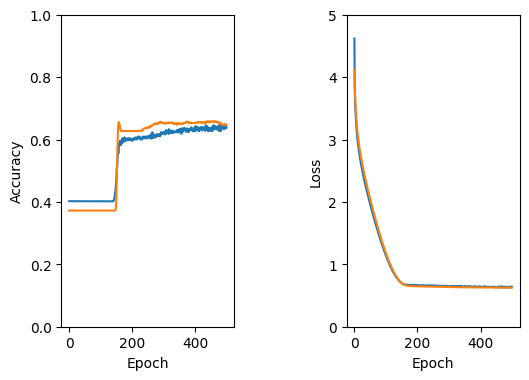

In [21]:
plot_classification_history(classification_history)

2. Clusterization

Model that divides data into clusters, that expected to be close to it's sectors

Probably the best approach is to pack the vector of close values into matrix and clusterize them. 

In [22]:
AGG_FUNCS = {
    col : ['mean', 'std', 'median'] for col in columns
}

def aggregate_stock(stock_df: pd.DataFrame, name: str) -> pd.DataFrame:
    
    for column in columns:
        stock_df[f'{column}_mean'] = stock_df[column].mean()
        stock_df[f'{column}_std'] = stock_df[column].std(ddof=0)
        stock_df[f'{column}_median'] = stock_df[column].median()
    stock_df = stock_df.head(1)
    stock_df.loc[:, 'Stock'] = [name]
    stock_df = stock_df.set_index('Stock').drop(columns, axis=1)
    return stock_df


def collect_financial_data(input_tickers: pd.DataFrame) -> pd.DataFrame: 
    aggregated_dfs = []
    for stock in stocks_list: 
        history = extract_history(input_tickers, stock)
        aggregated_stock = aggregate_stock(history, stock)
        aggregated_dfs.append(aggregated_stock)
    return pd.concat(aggregated_dfs, axis=0)

cluster_df = collect_financial_data(tickers_df)
cluster_df

C:\Users\strel\AppData\Local\Temp\ipykernel_36456\1457164709.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df.loc[:, 'Stock'] = [name]
C:\Users\strel\AppData\Local\Temp\ipykernel_36456\1457164709.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df.loc[:, 'Stock'] = [name]
C:\Users\strel\AppData\Local\Temp\ipykernel_36456\1457164709.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


,Open_mean,Open_std,Open_median,High_mean,High_std,High_median,Low_mean,Low_std,Low_median,Close_mean,Close_std,Close_median,Adj Close_mean,Adj Close_std,Adj Close_median,Volume_mean,Volume_std,Volume_median
Stock,,,,,,,,,,,,,,,,,,
MCACW,0.000000,0.000000,0.000000,0.017500,0.000000,0.017500,0.017500,0.000000,0.017500,0.017500,0.000000,0.017500,0.017500,0.000000,0.017500,3.000000e+02,0.000000e+00,300.0
BPT,5.940310,0.834894,5.720000,6.128295,0.881270,5.860000,5.727752,0.789234,5.450000,5.901318,0.832403,5.640000,5.901318,0.832403,5.640000,2.534728e+05,1.413374e+05,213300.0
DAC,64.800310,3.975753,66.040001,65.599069,3.900278,66.610001,64.052713,3.958665,65.459999,64.840775,3.915706,66.040001,64.266255,4.176980,65.849998,1.158346e+05,6.069695e+04,104900.0
COP,111.367752,8.978288,113.400002,112.596977,8.911605,115.629997,110.264419,8.932751,112.190002,111.394651,8.826494,113.709999,111.394651,8.826494,113.709999,5.131578e+06,2.150030e+06,4818800.0
STOK,7.964109,3.245910,6.470000,8.230388,3.398415,6.700000,7.703380,3.151871,6.270000,7.947364,3.276198,6.470000,7.947364,3.276198,6.470000,3.269593e+05,4.789984e+05,211900.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ASST,1.021054,0.510803,0.981000,1.092615,0.577919,1.020000,0.944497,0.460231,0.912000,0.999291,0.496716,0.959000,0.999291,0.496716,0.959000,1.055121e+06,8.000978e+06,66300.0
RGC,19.493430,4.445339,18.585000,19.939555,4.548417,18.855000,19.235141,4.457104,18.495000,19.545891,4.407241,18.585000,19.545891,4.407241,18.585000,1.494797e+03,2.314097e+03,600.0
EVV,9.197597,0.195312,9.210000,9.244961,0.194235,9.280000,9.154574,0.200859,9.170000,9.198372,0.200371,9.230000,9.198372,0.200371,9.230000,2.997708e+05,1.447557e+05,257600.0


d:\conda\envs\imta\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\strel\AppData\Local\Temp\ipykernel_36456\1014677861.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_df['cluster_label'] = kmeans.labels_


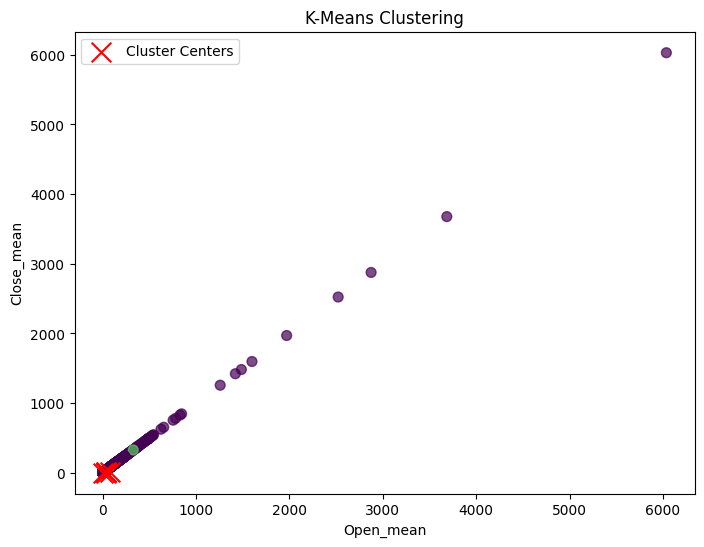

In [23]:
cluster_df = cluster_df.dropna()
kmeans = KMeans(n_clusters=5)
kmeans.fit(cluster_df)

cluster_df['cluster_label'] = kmeans.labels_

#probably compare by cartesian product
plt.figure(figsize=(8, 6))
plt.scatter(cluster_df['Open_mean'], cluster_df['Close_mean'], c=cluster_df['cluster_label'], cmap='viridis', s=50, alpha=0.7)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', s=200, marker='x', label='Cluster Centers')

plt.title('K-Means Clustering')
plt.xlabel('Open_mean')
plt.ylabel('Close_mean')
plt.legend()

plt.show()

3. Regression

Model that predicts next close price of a stock given the sequence of previous trades

RNN regression

In [491]:
# The Walt Disney Company stock, really, really old one
TARGET_TICKER = 'DIS'

def load_long_history():
    history = yf.download(TARGET_TICKER, period='max')
    return history
    
regression_data = load_long_history()
regression_data

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1962-01-02,0.092908,0.096026,0.092908,0.092908,0.058398,841958
1962-01-03,0.092908,0.094467,0.092908,0.094155,0.059182,801865
1962-01-04,0.094155,0.094467,0.093532,0.094155,0.059182,962238
1962-01-05,0.094155,0.094779,0.093844,0.094467,0.059378,962238
1962-01-08,0.094467,0.095714,0.092285,0.094155,0.059182,1282984
...,...,...,...,...,...,...
2023-10-19,85.260002,85.269997,83.169998,83.250000,83.250000,14316800
2023-10-20,82.900002,83.440002,82.610001,82.650002,82.650002,10425200
2023-10-23,82.080002,84.029999,80.910004,83.099998,83.099998,10772500


In [551]:
close_vals = regression_data['Close'].to_numpy()

mm = MinMaxScaler()
close_vals = mm.fit_transform(np.array(close_vals)[... , None]).squeeze()

close_vals

array([1.94608681e-04, 2.00786322e-04, 2.00786322e-04, ...,
       4.11413174e-01, 4.08738000e-01, 3.98953824e-01])

In [552]:
def split_input_target(sequence):
    history = sequence[:-1]
    target = sequence[-1]
    return history, target

In [554]:
regression_history = []
regression_target = []

SEQ_LENGTH = 64

for sequence in sliding_window_view(close_vals, SEQ_LENGTH + 1):
    history, target = split_input_target(sequence)

    regression_history.append(history)
    regression_target.append(target)

regression_dict = {
    'History': regression_history,
    'Target': regression_target
}

In [555]:
regression_df = pd.DataFrame.from_dict(regression_dict)

In [556]:
regression_df.sample(1)

,History,Target
3817,"[0.003285152665838268, 0.0032724256972308063, ...",0.003489


In [557]:
regression_train_df, regression_test_df = train_test_split(regression_df, test_size=0.2)

In [558]:
regression_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(128,  return_sequences=True, input_shape=(None, SEQ_LENGTH)),
    tf.keras.layers.Dense(1)
])

In [559]:
regression_model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=tf.keras.optimizers.Adam(2e-5),
            )

In [560]:
train_size = len(regression_train_df)
test_size = len(regression_test_df)

x_train = np.array(regression_train_df['History'].tolist()).reshape(train_size, 1, SEQ_LENGTH)
y_train = np.array(regression_train_df['Target'].tolist()).reshape(train_size, 1, 1)

x_test = np.array(regression_test_df['History'].tolist()).reshape(test_size, 1, SEQ_LENGTH)
y_test = np.array(regression_test_df['Target'].tolist()).reshape(test_size, 1, 1)

In [561]:
regression_history = regression_model.fit(x=x_train, y=y_train, validation_data=(x_test, y_test), epochs=100)

Epoch 1/100
388/388 [==============================] - 4s 5ms/step - loss: 0.0179 - val_loss: 5.1621e-04
Epoch 2/100
388/388 [==============================] - 2s 4ms/step - loss: 4.1363e-04 - val_loss: 4.0531e-04
Epoch 3/100
388/388 [==============================] - 2s 4ms/step - loss: 3.6346e-04 - val_loss: 3.6724e-04
Epoch 4/100
388/388 [==============================] - 2s 4ms/step - loss: 3.3015e-04 - val_loss: 3.3510e-04
Epoch 5/100
388/388 [==============================] - 2s 4ms/step - loss: 3.0252e-04 - val_loss: 3.0619e-04
Epoch 6/100
388/388 [==============================] - 2s 4ms/step - loss: 2.7996e-04 - val_loss: 2.8016e-04
Epoch 7/100
388/388 [==============================] - 2s 4ms/step - loss: 2.5751e-04 - val_loss: 2.5813e-04
Epoch 8/100
388/388 [==============================] - 1s 4ms/step - loss: 2.3711e-04 - val_loss: 2.3435e-04
Epoch 9/100
388/388 [==============================] - 2s 4ms/step - loss: 2.1997e-04 - val_loss: 2.1165e-04
Epoch 10/100
388/388 [=

In [562]:
test_loss = regression_model.evaluate(x=x_test, y=y_test)

print('Test Loss:', test_loss)

 1/97 [..............................] - ETA: 4s - loss: 2.7145e-05

97/97 [==============================] - 0s 3ms/step - loss: 3.9780e-05
Test Loss: 3.978032327722758e-05


In [563]:
def plot_regression_history(history):
    fig, ax = plt.subplots(1, 1)
    fig.tight_layout(pad=5.0)

    ax.plot(history.history['loss'], label='loss')
    ax.plot(history.history['val_loss'], label='val_loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_ylim([0, 0.001])

    plt.show()

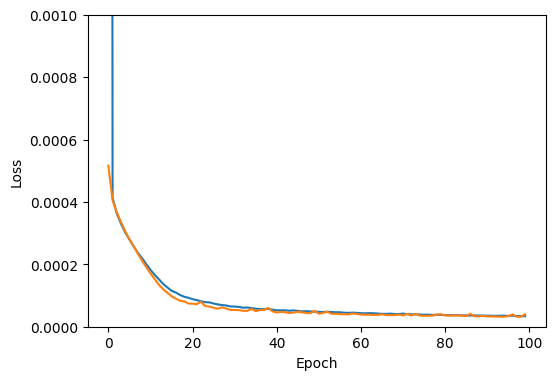

In [564]:
plot_regression_history(regression_history)

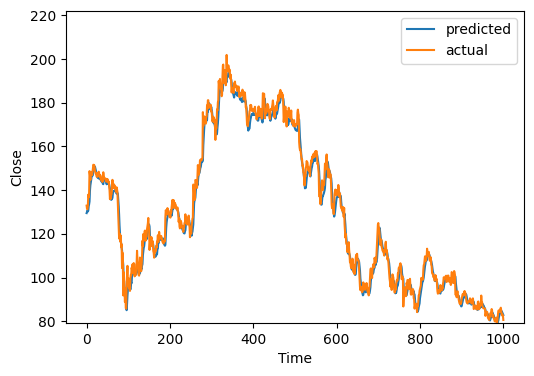

In [565]:
predictions = []
actual_values = []

def inverse_transform_scalar(n):
    return mm.inverse_transform(n.reshape(1, -1))[0]

segment = close_vals[-(1000 + SEQ_LENGTH + 1):]

for sequence in sliding_window_view(segment, SEQ_LENGTH + 1):
    history, target = split_input_target(sequence)

    prediction = regression_model.predict(history.reshape(1, 1, SEQ_LENGTH), verbose=0)
    predictions.append(inverse_transform_scalar(prediction.flatten()[0]))
    actual_values.append(inverse_transform_scalar(target))

fig, ax = plt.subplots(1, 1)
fig.tight_layout(pad=5.0)

ax.plot(predictions, label='predicted')
ax.plot(actual_values, label='actual')
ax.set_xlabel('Time')
ax.set_ylabel('Close')
ax.set_ylim([
        inverse_transform_scalar(np.min(segment)), 
        inverse_transform_scalar(np.max(segment)) * 1.1
    ])

plt.legend(loc="upper right")
plt.show()
